# Data/Model Iteration Using Flair For NER Task

This notebook improves upon our baseline model for the **named entity recognition (NER) task**. We'll be training a model using Flair embeddings on the [annotated NER corpus](https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus) dataset.

## Setup

Open this notebook in **Google Colab** and remember to turn on the GPU. The "standard" GPU in Colab is a Tesla T4 with only 15GB memory. Since out-of-memory errors were previously an issue when working on the baseline model, we'll be using a "premium" GPU: an A100 with 40GB memory.

In [1]:
!nvidia-smi

Fri Jan  6 21:12:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    56W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install dependencies:

In [2]:
!pip install -q flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.9/401.9 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 KB 35.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 63.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 KB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) .

## Load In Data

In a previous notebook, we created training, validation, and test sets in a text file format that Flair can read. **Upload those files to Colab.**

Read in text files to Flair (according to [Tutorial 6: Corpus](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_6_CORPUS.md#reading-your-own-sequence-labeling-dataset)):

In [3]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus

# Columns in the text files
columns = {0: 'text', 1: 'pos', 2: 'ner'}

# Data folder in which train, test and dev files reside
data_folder = '.'

# Initialize a corpus using column format, data folder and the names of the train, dev and test files
corpus = ColumnCorpus(data_folder, columns,
                              train_file='ner_flair_train.txt',
                            #   test_file='ner_flair_test.txt',
                              dev_file='ner_flair_valid.txt')

# Print the number of sentences read in
len(corpus.train), len(corpus.dev), len(corpus.test)

2023-01-06 21:13:56,452 Reading data from .
2023-01-06 21:13:56,454 Train: ner_flair_train.txt
2023-01-06 21:13:56,455 Dev: ner_flair_valid.txt
2023-01-06 21:13:56,456 Test: None


(34511, 4778, 3834)

In our baseline notebook, we were limited to using `ner_flair_train_tiny.txt` due to out-of-memory errors. Now that we're using a more powerful VM, we're using the full-sized `ner_flair_train.txt`.

Note that when `test_file` is omitted in `ColumnCorpus` above, Flair automatically grabs some data for `test_file` from `train_file`. That's fine, as we will ignore the test results below and only focus on the validation (dev) set. Keep the `test_file` line commented out because there is an unknown entity within it that gives an error during training because it's not in our corpus dictionary. We will investigate this issue further in future work.

## Training

To train a NER model using **Flair embeddings**, we follow [Tutorial 7: NER Training With Flair](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_7_TRAINING_A_MODEL.md#training-a-named-entity-recognition-ner-model-with-flair-embeddings), [Training Custom NER Model Using Flair](https://medium.com/thecyphy/training-custom-ner-model-using-flair-df1f9ea9c762), and [Train a NER Model](https://news.machinelearning.sg/posts/train_a_named_entity_recognition_model_using_flair/). For more details on Flair embeddings, see [Tutorial 3: Word Embeddings](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_3_WORD_EMBEDDING.md) and [Tutorial 4: List of All Word Embeddings](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_4_ELMO_BERT_FLAIR_EMBEDDING.md).

The benefit of **training a model vs. using a pre-trained model** is that with the former, we can learn our dataset's **custom entities**. With the latter, we would be limited to that particular model's entities.

In [4]:
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer

# Specify the NER label
label_type = 'ner'

# Make the label dictionary from the corpus
label_dict = corpus.make_label_dictionary(label_type=label_type)

# Initialize embedding stack with Flair and GloVe
embedding_types = [
    WordEmbeddings('glove'),
    FlairEmbeddings('news-forward'),
    FlairEmbeddings('news-backward'),
]
embeddings = StackedEmbeddings(embeddings=embedding_types)

# Initialize sequence tagger
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=label_dict,
                        tag_type=label_type,
                        use_crf=True)

# Initialize trainer
trainer = ModelTrainer(tagger, corpus)

# Start training
trainer.train('ner_04_results',
              learning_rate=0.1,
              mini_batch_size=32,
              write_weights=True,
              embeddings_storage_mode='cpu',
              max_epochs=40)

2023-01-06 21:14:41,619 Computing label dictionary. Progress:


34511it [00:00, 39301.37it/s]

2023-01-06 21:14:42,545 Dictionary created for label 'ner' with 9 values: geo (seen 27096 times), tim (seen 14610 times), org (seen 14444 times), per (seen 12287 times), gpe (seen 11361 times), art (seen 299 times), eve (seen 229 times), nat (seen 126 times)


2023-01-06 21:14:43,034 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmp7tl562mg


100%|██████████| 160000128/160000128 [00:06<00:00, 23043186.18B/s]

2023-01-06 21:14:50,337 copying /tmp/tmp7tl562mg to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2023-01-06 21:14:50,460 removing temp file /tmp/tmp7tl562mg
2023-01-06 21:14:50,840 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmpjfdbmbrk


100%|██████████| 21494764/21494764 [00:01<00:00, 14106601.86B/s]

2023-01-06 21:14:52,725 copying /tmp/tmpjfdbmbrk to cache at /root/.flair/embeddings/glove.gensim
2023-01-06 21:14:52,746 removing temp file /tmp/tmpjfdbmbrk


2023-01-06 21:14:53,968 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmp_xn17gwv


100%|██████████| 73034624/73034624 [00:03<00:00, 20412629.75B/s]

2023-01-06 21:14:57,906 copying /tmp/tmp_xn17gwv to cache at /root/.flair/embeddings/news-forward-0.4.1.pt


2023-01-06 21:14:57,963 removing temp file /tmp/tmp_xn17gwv
2023-01-06 21:15:09,603 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-backward-0.4.1.pt not found in cache, downloading to /tmp/tmpd1o40mqj


100%|██████████| 73034575/73034575 [00:03<00:00, 21054406.26B/s]

2023-01-06 21:15:13,431 copying /tmp/tmpd1o40mqj to cache at /root/.flair/embeddings/news-backward-0.4.1.pt


2023-01-06 21:15:13,488 removing temp file /tmp/tmpd1o40mqj
2023-01-06 21:15:13,709 SequenceTagger predicts: Dictionary with 33 tags: O, S-geo, B-geo, E-geo, I-geo, S-tim, B-tim, E-tim, I-tim, S-org, B-org, E-org, I-org, S-per, B-per, E-per, I-per, S-gpe, B-gpe, E-gpe, I-gpe, S-art, B-art, E-art, I-art, S-eve, B-eve, E-eve, I-eve, S-nat, B-nat, E-nat, I-nat
2023-01-06 21:15:13,931 ----------------------------------------------------------------------------------------------------
2023-01-06 21:15:13,933 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Langu

100%|██████████| 150/150 [00:32<00:00,  4.60it/s]

2023-01-06 21:18:28,558 Evaluating as a multi-label problem: False


2023-01-06 21:18:28,653 DEV : loss 0.1021013855934143 - f1-score (micro avg)  0.818
2023-01-06 21:18:29,131 BAD EPOCHS (no improvement): 0
2023-01-06 21:18:29,134 saving best model
2023-01-06 21:18:30,167 ----------------------------------------------------------------------------------------------------
2023-01-06 21:18:41,022 epoch 2 - iter 107/1079 - loss 0.14070223 - samples/sec: 316.13 - lr: 0.100000
2023-01-06 21:18:52,032 epoch 2 - iter 214/1079 - loss 0.13792294 - samples/sec: 311.89 - lr: 0.100000
2023-01-06 21:19:02,846 epoch 2 - iter 321/1079 - loss 0.13452211 - samples/sec: 317.48 - lr: 0.100000
2023-01-06 21:19:13,802 epoch 2 - iter 428/1079 - loss 0.13346487 - samples/sec: 313.40 - lr: 0.100000
2023-01-06 21:19:24,838 epoch 2 - iter 535/1079 - loss 0.13157298 - samples/sec: 311.10 - lr: 0.100000
2023-01-06 21:19:35,692 epoch 2 - iter 642/1079 - loss 0.13034693 - samples/sec: 316.34 - lr: 0.100000
2023-01-06 21:19:46,667 epoch 2 - iter 749/1079 - loss 0.12876653 - samples/

100%|██████████| 150/150 [00:20<00:00,  7.26it/s]


2023-01-06 21:20:41,071 Evaluating as a multi-label problem: False
2023-01-06 21:20:41,162 DEV : loss 0.08237498253583908 - f1-score (micro avg)  0.8333
2023-01-06 21:20:41,633 BAD EPOCHS (no improvement): 0
2023-01-06 21:20:41,635 saving best model
2023-01-06 21:20:42,935 ----------------------------------------------------------------------------------------------------
2023-01-06 21:20:53,762 epoch 3 - iter 107/1079 - loss 0.11301309 - samples/sec: 316.72 - lr: 0.100000
2023-01-06 21:21:04,743 epoch 3 - iter 214/1079 - loss 0.11039683 - samples/sec: 312.66 - lr: 0.100000
2023-01-06 21:21:15,641 epoch 3 - iter 321/1079 - loss 0.11150286 - samples/sec: 315.05 - lr: 0.100000
2023-01-06 21:21:26,483 epoch 3 - iter 428/1079 - loss 0.11144269 - samples/sec: 316.66 - lr: 0.100000
2023-01-06 21:21:37,378 epoch 3 - iter 535/1079 - loss 0.11189306 - samples/sec: 315.14 - lr: 0.100000
2023-01-06 21:21:48,384 epoch 3 - iter 642/1079 - loss 0.11080579 - samples/sec: 311.95 - lr: 0.100000
2023-01

100%|██████████| 150/150 [00:20<00:00,  7.21it/s]


2023-01-06 21:22:54,123 Evaluating as a multi-label problem: False
2023-01-06 21:22:54,217 DEV : loss 0.07623609155416489 - f1-score (micro avg)  0.8369
2023-01-06 21:22:54,692 BAD EPOCHS (no improvement): 0
2023-01-06 21:22:54,694 saving best model
2023-01-06 21:22:55,999 ----------------------------------------------------------------------------------------------------
2023-01-06 21:23:06,854 epoch 4 - iter 107/1079 - loss 0.10183927 - samples/sec: 315.94 - lr: 0.100000
2023-01-06 21:23:17,960 epoch 4 - iter 214/1079 - loss 0.10126273 - samples/sec: 309.13 - lr: 0.100000
2023-01-06 21:23:28,660 epoch 4 - iter 321/1079 - loss 0.10016268 - samples/sec: 320.90 - lr: 0.100000
2023-01-06 21:23:39,447 epoch 4 - iter 428/1079 - loss 0.10183068 - samples/sec: 318.36 - lr: 0.100000
2023-01-06 21:23:50,362 epoch 4 - iter 535/1079 - loss 0.10111898 - samples/sec: 314.53 - lr: 0.100000
2023-01-06 21:24:01,186 epoch 4 - iter 642/1079 - loss 0.10089163 - samples/sec: 317.22 - lr: 0.100000
2023-01

100%|██████████| 150/150 [00:25<00:00,  5.84it/s]


2023-01-06 21:25:11,634 Evaluating as a multi-label problem: False
2023-01-06 21:25:11,728 DEV : loss 0.07459072768688202 - f1-score (micro avg)  0.8302
2023-01-06 21:25:12,205 BAD EPOCHS (no improvement): 1
2023-01-06 21:25:12,207 ----------------------------------------------------------------------------------------------------
2023-01-06 21:25:22,915 epoch 5 - iter 107/1079 - loss 0.09912974 - samples/sec: 320.28 - lr: 0.100000
2023-01-06 21:25:33,800 epoch 5 - iter 214/1079 - loss 0.09730326 - samples/sec: 315.45 - lr: 0.100000
2023-01-06 21:25:44,661 epoch 5 - iter 321/1079 - loss 0.09744235 - samples/sec: 316.14 - lr: 0.100000
2023-01-06 21:25:55,568 epoch 5 - iter 428/1079 - loss 0.09677576 - samples/sec: 314.79 - lr: 0.100000
2023-01-06 21:26:06,535 epoch 5 - iter 535/1079 - loss 0.09631437 - samples/sec: 313.07 - lr: 0.100000
2023-01-06 21:26:17,382 epoch 5 - iter 642/1079 - loss 0.09576141 - samples/sec: 316.53 - lr: 0.100000
2023-01-06 21:26:28,262 epoch 5 - iter 749/1079 -

100%|██████████| 150/150 [00:20<00:00,  7.24it/s]


2023-01-06 21:27:22,962 Evaluating as a multi-label problem: False
2023-01-06 21:27:23,059 DEV : loss 0.0686621442437172 - f1-score (micro avg)  0.8441
2023-01-06 21:27:23,532 BAD EPOCHS (no improvement): 0
2023-01-06 21:27:23,534 saving best model
2023-01-06 21:27:24,839 ----------------------------------------------------------------------------------------------------
2023-01-06 21:27:35,742 epoch 6 - iter 107/1079 - loss 0.09264522 - samples/sec: 314.54 - lr: 0.100000
2023-01-06 21:27:46,561 epoch 6 - iter 214/1079 - loss 0.09100210 - samples/sec: 317.36 - lr: 0.100000
2023-01-06 21:27:57,629 epoch 6 - iter 321/1079 - loss 0.09062528 - samples/sec: 310.20 - lr: 0.100000
2023-01-06 21:28:08,570 epoch 6 - iter 428/1079 - loss 0.09064982 - samples/sec: 313.80 - lr: 0.100000
2023-01-06 21:28:19,533 epoch 6 - iter 535/1079 - loss 0.09101804 - samples/sec: 313.19 - lr: 0.100000
2023-01-06 21:28:30,553 epoch 6 - iter 642/1079 - loss 0.09094034 - samples/sec: 311.57 - lr: 0.100000
2023-01-

100%|██████████| 150/150 [00:20<00:00,  7.24it/s]


2023-01-06 21:29:35,646 Evaluating as a multi-label problem: False
2023-01-06 21:29:35,738 DEV : loss 0.06595407426357269 - f1-score (micro avg)  0.8461
2023-01-06 21:29:36,219 BAD EPOCHS (no improvement): 0
2023-01-06 21:29:36,221 saving best model
2023-01-06 21:29:37,503 ----------------------------------------------------------------------------------------------------
2023-01-06 21:29:48,392 epoch 7 - iter 107/1079 - loss 0.08675429 - samples/sec: 315.33 - lr: 0.100000
2023-01-06 21:29:59,305 epoch 7 - iter 214/1079 - loss 0.08876426 - samples/sec: 314.62 - lr: 0.100000
2023-01-06 21:30:10,105 epoch 7 - iter 321/1079 - loss 0.08802265 - samples/sec: 317.93 - lr: 0.100000
2023-01-06 21:30:20,970 epoch 7 - iter 428/1079 - loss 0.08841035 - samples/sec: 316.01 - lr: 0.100000
2023-01-06 21:30:31,839 epoch 7 - iter 535/1079 - loss 0.08821589 - samples/sec: 315.90 - lr: 0.100000
2023-01-06 21:30:42,757 epoch 7 - iter 642/1079 - loss 0.08861815 - samples/sec: 314.48 - lr: 0.100000
2023-01

100%|██████████| 150/150 [00:25<00:00,  5.82it/s]


2023-01-06 21:31:53,178 Evaluating as a multi-label problem: False
2023-01-06 21:31:53,277 DEV : loss 0.06496972590684891 - f1-score (micro avg)  0.848
2023-01-06 21:31:53,752 BAD EPOCHS (no improvement): 0
2023-01-06 21:31:53,754 saving best model
2023-01-06 21:31:55,212 ----------------------------------------------------------------------------------------------------
2023-01-06 21:32:06,163 epoch 8 - iter 107/1079 - loss 0.08484707 - samples/sec: 313.19 - lr: 0.100000
2023-01-06 21:32:17,100 epoch 8 - iter 214/1079 - loss 0.08575132 - samples/sec: 313.90 - lr: 0.100000
2023-01-06 21:32:28,107 epoch 8 - iter 321/1079 - loss 0.08637125 - samples/sec: 311.91 - lr: 0.100000
2023-01-06 21:32:39,091 epoch 8 - iter 428/1079 - loss 0.08694198 - samples/sec: 312.56 - lr: 0.100000
2023-01-06 21:32:49,876 epoch 8 - iter 535/1079 - loss 0.08697973 - samples/sec: 318.37 - lr: 0.100000
2023-01-06 21:33:00,713 epoch 8 - iter 642/1079 - loss 0.08591549 - samples/sec: 316.86 - lr: 0.100000
2023-01-

100%|██████████| 150/150 [00:20<00:00,  7.16it/s]


2023-01-06 21:34:06,399 Evaluating as a multi-label problem: False
2023-01-06 21:34:06,494 DEV : loss 0.06331592798233032 - f1-score (micro avg)  0.8481
2023-01-06 21:34:06,975 BAD EPOCHS (no improvement): 0
2023-01-06 21:34:06,978 saving best model
2023-01-06 21:34:08,322 ----------------------------------------------------------------------------------------------------
2023-01-06 21:34:19,098 epoch 9 - iter 107/1079 - loss 0.08201000 - samples/sec: 318.26 - lr: 0.100000
2023-01-06 21:34:30,160 epoch 9 - iter 214/1079 - loss 0.08203510 - samples/sec: 310.37 - lr: 0.100000
2023-01-06 21:34:41,270 epoch 9 - iter 321/1079 - loss 0.08334938 - samples/sec: 309.00 - lr: 0.100000
2023-01-06 21:34:52,122 epoch 9 - iter 428/1079 - loss 0.08329386 - samples/sec: 316.45 - lr: 0.100000
2023-01-06 21:35:03,010 epoch 9 - iter 535/1079 - loss 0.08331292 - samples/sec: 315.34 - lr: 0.100000
2023-01-06 21:35:13,923 epoch 9 - iter 642/1079 - loss 0.08319716 - samples/sec: 314.62 - lr: 0.100000
2023-01

100%|██████████| 150/150 [00:20<00:00,  7.25it/s]


2023-01-06 21:36:19,788 Evaluating as a multi-label problem: False
2023-01-06 21:36:19,879 DEV : loss 0.06309813261032104 - f1-score (micro avg)  0.8495
2023-01-06 21:36:20,352 BAD EPOCHS (no improvement): 0
2023-01-06 21:36:20,355 saving best model
2023-01-06 21:36:21,651 ----------------------------------------------------------------------------------------------------
2023-01-06 21:36:32,635 epoch 10 - iter 107/1079 - loss 0.08131397 - samples/sec: 312.60 - lr: 0.100000
2023-01-06 21:36:43,491 epoch 10 - iter 214/1079 - loss 0.08191340 - samples/sec: 316.28 - lr: 0.100000
2023-01-06 21:36:54,247 epoch 10 - iter 321/1079 - loss 0.08200178 - samples/sec: 319.20 - lr: 0.100000
2023-01-06 21:37:05,124 epoch 10 - iter 428/1079 - loss 0.08308791 - samples/sec: 315.65 - lr: 0.100000
2023-01-06 21:37:15,862 epoch 10 - iter 535/1079 - loss 0.08238968 - samples/sec: 319.77 - lr: 0.100000
2023-01-06 21:37:26,794 epoch 10 - iter 642/1079 - loss 0.08213530 - samples/sec: 314.09 - lr: 0.100000
2

100%|██████████| 150/150 [00:25<00:00,  5.83it/s]


2023-01-06 21:38:37,408 Evaluating as a multi-label problem: False
2023-01-06 21:38:37,503 DEV : loss 0.06283058971166611 - f1-score (micro avg)  0.8495
2023-01-06 21:38:37,979 BAD EPOCHS (no improvement): 1
2023-01-06 21:38:37,981 ----------------------------------------------------------------------------------------------------
2023-01-06 21:38:49,048 epoch 11 - iter 107/1079 - loss 0.07716402 - samples/sec: 309.87 - lr: 0.100000
2023-01-06 21:39:00,028 epoch 11 - iter 214/1079 - loss 0.08013581 - samples/sec: 312.71 - lr: 0.100000
2023-01-06 21:39:10,954 epoch 11 - iter 321/1079 - loss 0.08027682 - samples/sec: 314.23 - lr: 0.100000
2023-01-06 21:39:22,004 epoch 11 - iter 428/1079 - loss 0.08171565 - samples/sec: 310.72 - lr: 0.100000
2023-01-06 21:39:32,840 epoch 11 - iter 535/1079 - loss 0.08057896 - samples/sec: 316.84 - lr: 0.100000
2023-01-06 21:39:43,599 epoch 11 - iter 642/1079 - loss 0.08059481 - samples/sec: 319.15 - lr: 0.100000
2023-01-06 21:39:54,449 epoch 11 - iter 749

100%|██████████| 150/150 [00:21<00:00,  7.13it/s]


2023-01-06 21:40:49,313 Evaluating as a multi-label problem: False
2023-01-06 21:40:49,407 DEV : loss 0.06206005811691284 - f1-score (micro avg)  0.8523
2023-01-06 21:40:49,883 BAD EPOCHS (no improvement): 0
2023-01-06 21:40:49,886 saving best model
2023-01-06 21:40:51,189 ----------------------------------------------------------------------------------------------------
2023-01-06 21:41:02,460 epoch 12 - iter 107/1079 - loss 0.07939987 - samples/sec: 304.66 - lr: 0.100000
2023-01-06 21:41:13,538 epoch 12 - iter 214/1079 - loss 0.08077443 - samples/sec: 309.92 - lr: 0.100000
2023-01-06 21:41:24,331 epoch 12 - iter 321/1079 - loss 0.08081499 - samples/sec: 318.13 - lr: 0.100000
2023-01-06 21:41:35,482 epoch 12 - iter 428/1079 - loss 0.08032936 - samples/sec: 307.90 - lr: 0.100000
2023-01-06 21:41:46,285 epoch 12 - iter 535/1079 - loss 0.08042702 - samples/sec: 317.81 - lr: 0.100000
2023-01-06 21:41:57,356 epoch 12 - iter 642/1079 - loss 0.08012417 - samples/sec: 310.15 - lr: 0.100000
2

100%|██████████| 150/150 [00:20<00:00,  7.20it/s]


2023-01-06 21:43:03,522 Evaluating as a multi-label problem: False
2023-01-06 21:43:03,617 DEV : loss 0.06197437644004822 - f1-score (micro avg)  0.8508
2023-01-06 21:43:04,094 BAD EPOCHS (no improvement): 1
2023-01-06 21:43:04,096 ----------------------------------------------------------------------------------------------------
2023-01-06 21:43:14,913 epoch 13 - iter 107/1079 - loss 0.07655801 - samples/sec: 317.06 - lr: 0.100000
2023-01-06 21:43:25,990 epoch 13 - iter 214/1079 - loss 0.07642485 - samples/sec: 309.96 - lr: 0.100000
2023-01-06 21:43:37,108 epoch 13 - iter 321/1079 - loss 0.07692601 - samples/sec: 308.83 - lr: 0.100000
2023-01-06 21:43:48,187 epoch 13 - iter 428/1079 - loss 0.07662697 - samples/sec: 309.98 - lr: 0.100000
2023-01-06 21:43:59,235 epoch 13 - iter 535/1079 - loss 0.07676971 - samples/sec: 310.74 - lr: 0.100000
2023-01-06 21:44:10,230 epoch 13 - iter 642/1079 - loss 0.07702801 - samples/sec: 312.26 - lr: 0.100000
2023-01-06 21:44:26,148 epoch 13 - iter 749

100%|██████████| 150/150 [00:20<00:00,  7.15it/s]


2023-01-06 21:45:20,883 Evaluating as a multi-label problem: False
2023-01-06 21:45:20,976 DEV : loss 0.06138196587562561 - f1-score (micro avg)  0.8507
2023-01-06 21:45:21,451 BAD EPOCHS (no improvement): 2
2023-01-06 21:45:21,453 ----------------------------------------------------------------------------------------------------
2023-01-06 21:45:32,593 epoch 14 - iter 107/1079 - loss 0.07515951 - samples/sec: 307.80 - lr: 0.100000
2023-01-06 21:45:43,407 epoch 14 - iter 214/1079 - loss 0.07643026 - samples/sec: 317.54 - lr: 0.100000
2023-01-06 21:45:54,420 epoch 14 - iter 321/1079 - loss 0.07679845 - samples/sec: 311.78 - lr: 0.100000
2023-01-06 21:46:05,376 epoch 14 - iter 428/1079 - loss 0.07703734 - samples/sec: 313.39 - lr: 0.100000
2023-01-06 21:46:16,250 epoch 14 - iter 535/1079 - loss 0.07685191 - samples/sec: 315.72 - lr: 0.100000
2023-01-06 21:46:27,423 epoch 14 - iter 642/1079 - loss 0.07638783 - samples/sec: 307.29 - lr: 0.100000
2023-01-06 21:46:38,493 epoch 14 - iter 749

100%|██████████| 150/150 [00:20<00:00,  7.22it/s]


2023-01-06 21:47:33,204 Evaluating as a multi-label problem: False
2023-01-06 21:47:33,299 DEV : loss 0.06048334762454033 - f1-score (micro avg)  0.8544
2023-01-06 21:47:33,793 BAD EPOCHS (no improvement): 0
2023-01-06 21:47:33,795 saving best model
2023-01-06 21:47:35,124 ----------------------------------------------------------------------------------------------------
2023-01-06 21:47:46,364 epoch 15 - iter 107/1079 - loss 0.07671818 - samples/sec: 305.11 - lr: 0.100000
2023-01-06 21:47:57,184 epoch 15 - iter 214/1079 - loss 0.07479474 - samples/sec: 317.36 - lr: 0.100000
2023-01-06 21:48:08,049 epoch 15 - iter 321/1079 - loss 0.07597693 - samples/sec: 316.01 - lr: 0.100000
2023-01-06 21:48:19,394 epoch 15 - iter 428/1079 - loss 0.07631390 - samples/sec: 302.61 - lr: 0.100000
2023-01-06 21:48:30,420 epoch 15 - iter 535/1079 - loss 0.07606613 - samples/sec: 311.36 - lr: 0.100000
2023-01-06 21:48:41,339 epoch 15 - iter 642/1079 - loss 0.07593634 - samples/sec: 314.47 - lr: 0.100000
2

100%|██████████| 150/150 [00:20<00:00,  7.22it/s]


2023-01-06 21:49:46,923 Evaluating as a multi-label problem: False
2023-01-06 21:49:47,023 DEV : loss 0.061188410967588425 - f1-score (micro avg)  0.8563
2023-01-06 21:49:47,496 BAD EPOCHS (no improvement): 0
2023-01-06 21:49:47,498 saving best model
2023-01-06 21:49:48,827 ----------------------------------------------------------------------------------------------------
2023-01-06 21:50:00,097 epoch 16 - iter 107/1079 - loss 0.07203931 - samples/sec: 304.32 - lr: 0.100000
2023-01-06 21:50:16,028 epoch 16 - iter 214/1079 - loss 0.07340321 - samples/sec: 215.34 - lr: 0.100000
2023-01-06 21:50:27,065 epoch 16 - iter 321/1079 - loss 0.07365672 - samples/sec: 311.06 - lr: 0.100000
2023-01-06 21:50:38,010 epoch 16 - iter 428/1079 - loss 0.07364936 - samples/sec: 313.71 - lr: 0.100000
2023-01-06 21:50:48,970 epoch 16 - iter 535/1079 - loss 0.07389375 - samples/sec: 313.24 - lr: 0.100000
2023-01-06 21:50:59,969 epoch 16 - iter 642/1079 - loss 0.07437219 - samples/sec: 312.16 - lr: 0.100000


100%|██████████| 150/150 [00:20<00:00,  7.20it/s]


2023-01-06 21:52:05,258 Evaluating as a multi-label problem: False
2023-01-06 21:52:05,351 DEV : loss 0.060550808906555176 - f1-score (micro avg)  0.8509
2023-01-06 21:52:05,825 BAD EPOCHS (no improvement): 1
2023-01-06 21:52:05,828 ----------------------------------------------------------------------------------------------------
2023-01-06 21:52:16,851 epoch 17 - iter 107/1079 - loss 0.07151860 - samples/sec: 311.11 - lr: 0.100000
2023-01-06 21:52:27,895 epoch 17 - iter 214/1079 - loss 0.07232130 - samples/sec: 310.86 - lr: 0.100000
2023-01-06 21:52:38,715 epoch 17 - iter 321/1079 - loss 0.07217866 - samples/sec: 317.34 - lr: 0.100000
2023-01-06 21:52:49,734 epoch 17 - iter 428/1079 - loss 0.07270209 - samples/sec: 311.58 - lr: 0.100000
2023-01-06 21:53:00,507 epoch 17 - iter 535/1079 - loss 0.07265555 - samples/sec: 318.80 - lr: 0.100000
2023-01-06 21:53:11,186 epoch 17 - iter 642/1079 - loss 0.07299493 - samples/sec: 321.53 - lr: 0.100000
2023-01-06 21:53:22,091 epoch 17 - iter 74

100%|██████████| 150/150 [00:20<00:00,  7.26it/s]


2023-01-06 21:54:16,361 Evaluating as a multi-label problem: False
2023-01-06 21:54:16,453 DEV : loss 0.05978919193148613 - f1-score (micro avg)  0.8539
2023-01-06 21:54:16,934 BAD EPOCHS (no improvement): 2
2023-01-06 21:54:16,936 ----------------------------------------------------------------------------------------------------
2023-01-06 21:54:27,913 epoch 18 - iter 107/1079 - loss 0.07481781 - samples/sec: 312.41 - lr: 0.100000
2023-01-06 21:54:38,800 epoch 18 - iter 214/1079 - loss 0.07591063 - samples/sec: 315.34 - lr: 0.100000
2023-01-06 21:54:49,705 epoch 18 - iter 321/1079 - loss 0.07496758 - samples/sec: 314.91 - lr: 0.100000
2023-01-06 21:55:00,704 epoch 18 - iter 428/1079 - loss 0.07459294 - samples/sec: 312.21 - lr: 0.100000
2023-01-06 21:55:11,647 epoch 18 - iter 535/1079 - loss 0.07369026 - samples/sec: 313.72 - lr: 0.100000
2023-01-06 21:55:22,562 epoch 18 - iter 642/1079 - loss 0.07342644 - samples/sec: 314.55 - lr: 0.100000
2023-01-06 21:55:33,510 epoch 18 - iter 749

100%|██████████| 150/150 [00:25<00:00,  5.79it/s]


2023-01-06 21:56:33,218 Evaluating as a multi-label problem: False
2023-01-06 21:56:33,314 DEV : loss 0.06013716757297516 - f1-score (micro avg)  0.8544
2023-01-06 21:56:33,802 BAD EPOCHS (no improvement): 3
2023-01-06 21:56:33,804 ----------------------------------------------------------------------------------------------------
2023-01-06 21:56:45,107 epoch 19 - iter 107/1079 - loss 0.07203331 - samples/sec: 303.38 - lr: 0.100000
2023-01-06 21:56:56,104 epoch 19 - iter 214/1079 - loss 0.07332511 - samples/sec: 312.18 - lr: 0.100000
2023-01-06 21:57:07,180 epoch 19 - iter 321/1079 - loss 0.07220883 - samples/sec: 310.03 - lr: 0.100000
2023-01-06 21:57:18,139 epoch 19 - iter 428/1079 - loss 0.07143099 - samples/sec: 313.29 - lr: 0.100000
2023-01-06 21:57:29,016 epoch 19 - iter 535/1079 - loss 0.07183417 - samples/sec: 315.66 - lr: 0.100000
2023-01-06 21:57:40,123 epoch 19 - iter 642/1079 - loss 0.07198685 - samples/sec: 309.12 - lr: 0.100000
2023-01-06 21:57:51,129 epoch 19 - iter 749

100%|██████████| 150/150 [00:20<00:00,  7.24it/s]


2023-01-06 21:58:45,355 Evaluating as a multi-label problem: False
2023-01-06 21:58:45,448 DEV : loss 0.05935181677341461 - f1-score (micro avg)  0.8556
2023-01-06 21:58:45,941 Epoch    19: reducing learning rate of group 0 to 5.0000e-02.
2023-01-06 21:58:45,943 BAD EPOCHS (no improvement): 4
2023-01-06 21:58:45,946 ----------------------------------------------------------------------------------------------------
2023-01-06 21:58:56,847 epoch 20 - iter 107/1079 - loss 0.06736342 - samples/sec: 314.60 - lr: 0.050000
2023-01-06 21:59:07,759 epoch 20 - iter 214/1079 - loss 0.06873246 - samples/sec: 314.65 - lr: 0.050000
2023-01-06 21:59:18,839 epoch 20 - iter 321/1079 - loss 0.06855096 - samples/sec: 309.86 - lr: 0.050000
2023-01-06 21:59:29,960 epoch 20 - iter 428/1079 - loss 0.06889960 - samples/sec: 308.70 - lr: 0.050000
2023-01-06 21:59:40,811 epoch 20 - iter 535/1079 - loss 0.06888111 - samples/sec: 316.41 - lr: 0.050000
2023-01-06 21:59:51,791 epoch 20 - iter 642/1079 - loss 0.068

100%|██████████| 150/150 [00:20<00:00,  7.18it/s]


2023-01-06 22:00:57,429 Evaluating as a multi-label problem: False
2023-01-06 22:00:57,522 DEV : loss 0.05731910467147827 - f1-score (micro avg)  0.8574
2023-01-06 22:00:58,003 BAD EPOCHS (no improvement): 0
2023-01-06 22:00:58,005 saving best model
2023-01-06 22:00:59,309 ----------------------------------------------------------------------------------------------------
2023-01-06 22:01:10,331 epoch 21 - iter 107/1079 - loss 0.06642188 - samples/sec: 311.55 - lr: 0.050000
2023-01-06 22:01:21,239 epoch 21 - iter 214/1079 - loss 0.06589880 - samples/sec: 314.78 - lr: 0.050000
2023-01-06 22:01:32,149 epoch 21 - iter 321/1079 - loss 0.06629084 - samples/sec: 314.71 - lr: 0.050000
2023-01-06 22:01:43,155 epoch 21 - iter 428/1079 - loss 0.06647165 - samples/sec: 311.94 - lr: 0.050000
2023-01-06 22:01:54,189 epoch 21 - iter 535/1079 - loss 0.06627732 - samples/sec: 311.17 - lr: 0.050000
2023-01-06 22:02:05,170 epoch 21 - iter 642/1079 - loss 0.06638177 - samples/sec: 312.66 - lr: 0.050000
2

100%|██████████| 150/150 [00:25<00:00,  5.79it/s]


2023-01-06 22:03:16,021 Evaluating as a multi-label problem: False
2023-01-06 22:03:16,114 DEV : loss 0.057833921164274216 - f1-score (micro avg)  0.8565
2023-01-06 22:03:16,588 BAD EPOCHS (no improvement): 1
2023-01-06 22:03:16,590 ----------------------------------------------------------------------------------------------------
2023-01-06 22:03:27,537 epoch 22 - iter 107/1079 - loss 0.06474640 - samples/sec: 313.28 - lr: 0.050000
2023-01-06 22:03:38,408 epoch 22 - iter 214/1079 - loss 0.06557602 - samples/sec: 315.81 - lr: 0.050000
2023-01-06 22:03:49,314 epoch 22 - iter 321/1079 - loss 0.06553084 - samples/sec: 314.88 - lr: 0.050000
2023-01-06 22:04:00,270 epoch 22 - iter 428/1079 - loss 0.06498410 - samples/sec: 313.38 - lr: 0.050000
2023-01-06 22:04:11,404 epoch 22 - iter 535/1079 - loss 0.06496508 - samples/sec: 308.40 - lr: 0.050000
2023-01-06 22:04:22,292 epoch 22 - iter 642/1079 - loss 0.06549080 - samples/sec: 315.34 - lr: 0.050000
2023-01-06 22:04:33,290 epoch 22 - iter 74

100%|██████████| 150/150 [00:20<00:00,  7.22it/s]


2023-01-06 22:05:27,809 Evaluating as a multi-label problem: False
2023-01-06 22:05:27,902 DEV : loss 0.057187389582395554 - f1-score (micro avg)  0.8541
2023-01-06 22:05:28,374 BAD EPOCHS (no improvement): 2
2023-01-06 22:05:28,377 ----------------------------------------------------------------------------------------------------
2023-01-06 22:05:39,282 epoch 23 - iter 107/1079 - loss 0.06684378 - samples/sec: 314.48 - lr: 0.050000
2023-01-06 22:05:50,321 epoch 23 - iter 214/1079 - loss 0.06509731 - samples/sec: 311.00 - lr: 0.050000
2023-01-06 22:06:01,292 epoch 23 - iter 321/1079 - loss 0.06506632 - samples/sec: 312.93 - lr: 0.050000
2023-01-06 22:06:12,095 epoch 23 - iter 428/1079 - loss 0.06501317 - samples/sec: 317.82 - lr: 0.050000
2023-01-06 22:06:22,977 epoch 23 - iter 535/1079 - loss 0.06512378 - samples/sec: 315.52 - lr: 0.050000
2023-01-06 22:06:33,817 epoch 23 - iter 642/1079 - loss 0.06536839 - samples/sec: 316.73 - lr: 0.050000
2023-01-06 22:06:44,621 epoch 23 - iter 74

100%|██████████| 150/150 [00:20<00:00,  7.27it/s]


2023-01-06 22:07:38,952 Evaluating as a multi-label problem: False
2023-01-06 22:07:39,047 DEV : loss 0.0574125200510025 - f1-score (micro avg)  0.856
2023-01-06 22:07:39,521 BAD EPOCHS (no improvement): 3
2023-01-06 22:07:39,523 ----------------------------------------------------------------------------------------------------
2023-01-06 22:07:50,251 epoch 24 - iter 107/1079 - loss 0.06365898 - samples/sec: 319.69 - lr: 0.050000
2023-01-06 22:08:01,164 epoch 24 - iter 214/1079 - loss 0.06319487 - samples/sec: 314.61 - lr: 0.050000
2023-01-06 22:08:12,156 epoch 24 - iter 321/1079 - loss 0.06293175 - samples/sec: 312.35 - lr: 0.050000
2023-01-06 22:08:23,010 epoch 24 - iter 428/1079 - loss 0.06408564 - samples/sec: 316.32 - lr: 0.050000
2023-01-06 22:08:33,987 epoch 24 - iter 535/1079 - loss 0.06393440 - samples/sec: 312.77 - lr: 0.050000
2023-01-06 22:08:44,757 epoch 24 - iter 642/1079 - loss 0.06406496 - samples/sec: 318.83 - lr: 0.050000
2023-01-06 22:08:55,681 epoch 24 - iter 749/1

100%|██████████| 150/150 [00:25<00:00,  5.85it/s]


2023-01-06 22:09:54,610 Evaluating as a multi-label problem: False
2023-01-06 22:09:54,702 DEV : loss 0.05679253861308098 - f1-score (micro avg)  0.8584
2023-01-06 22:09:55,177 BAD EPOCHS (no improvement): 0
2023-01-06 22:09:55,179 saving best model
2023-01-06 22:09:56,464 ----------------------------------------------------------------------------------------------------
2023-01-06 22:10:07,476 epoch 25 - iter 107/1079 - loss 0.06064416 - samples/sec: 311.81 - lr: 0.050000
2023-01-06 22:10:18,532 epoch 25 - iter 214/1079 - loss 0.06054928 - samples/sec: 310.56 - lr: 0.050000
2023-01-06 22:10:29,214 epoch 25 - iter 321/1079 - loss 0.06073095 - samples/sec: 321.43 - lr: 0.050000
2023-01-06 22:10:40,059 epoch 25 - iter 428/1079 - loss 0.06169839 - samples/sec: 316.58 - lr: 0.050000
2023-01-06 22:10:50,997 epoch 25 - iter 535/1079 - loss 0.06248856 - samples/sec: 313.89 - lr: 0.050000
2023-01-06 22:11:01,868 epoch 25 - iter 642/1079 - loss 0.06296447 - samples/sec: 315.81 - lr: 0.050000
2

100%|██████████| 150/150 [00:20<00:00,  7.22it/s]


2023-01-06 22:12:07,560 Evaluating as a multi-label problem: False
2023-01-06 22:12:07,658 DEV : loss 0.05687025934457779 - f1-score (micro avg)  0.8587
2023-01-06 22:12:08,138 BAD EPOCHS (no improvement): 0
2023-01-06 22:12:08,140 saving best model
2023-01-06 22:12:09,441 ----------------------------------------------------------------------------------------------------
2023-01-06 22:12:20,405 epoch 26 - iter 107/1079 - loss 0.06342667 - samples/sec: 313.17 - lr: 0.050000
2023-01-06 22:12:31,430 epoch 26 - iter 214/1079 - loss 0.06538008 - samples/sec: 311.43 - lr: 0.050000
2023-01-06 22:12:42,343 epoch 26 - iter 321/1079 - loss 0.06497729 - samples/sec: 314.67 - lr: 0.050000
2023-01-06 22:12:53,502 epoch 26 - iter 428/1079 - loss 0.06421826 - samples/sec: 307.67 - lr: 0.050000
2023-01-06 22:13:04,637 epoch 26 - iter 535/1079 - loss 0.06366391 - samples/sec: 308.49 - lr: 0.050000
2023-01-06 22:13:15,559 epoch 26 - iter 642/1079 - loss 0.06337871 - samples/sec: 314.34 - lr: 0.050000
2

100%|██████████| 150/150 [00:20<00:00,  7.19it/s]


2023-01-06 22:14:21,453 Evaluating as a multi-label problem: False
2023-01-06 22:14:21,551 DEV : loss 0.05568591505289078 - f1-score (micro avg)  0.8574
2023-01-06 22:14:22,035 BAD EPOCHS (no improvement): 1
2023-01-06 22:14:22,038 ----------------------------------------------------------------------------------------------------
2023-01-06 22:14:33,139 epoch 27 - iter 107/1079 - loss 0.06443961 - samples/sec: 308.89 - lr: 0.050000
2023-01-06 22:14:44,097 epoch 27 - iter 214/1079 - loss 0.06277798 - samples/sec: 313.35 - lr: 0.050000
2023-01-06 22:14:55,055 epoch 27 - iter 321/1079 - loss 0.06288707 - samples/sec: 313.33 - lr: 0.050000
2023-01-06 22:15:06,302 epoch 27 - iter 428/1079 - loss 0.06333892 - samples/sec: 305.28 - lr: 0.050000
2023-01-06 22:15:17,155 epoch 27 - iter 535/1079 - loss 0.06275534 - samples/sec: 316.35 - lr: 0.050000
2023-01-06 22:15:28,017 epoch 27 - iter 642/1079 - loss 0.06232944 - samples/sec: 316.15 - lr: 0.050000
2023-01-06 22:15:39,130 epoch 27 - iter 749

100%|██████████| 150/150 [00:25<00:00,  5.79it/s]


2023-01-06 22:16:38,728 Evaluating as a multi-label problem: False
2023-01-06 22:16:38,822 DEV : loss 0.05694800987839699 - f1-score (micro avg)  0.859
2023-01-06 22:16:39,295 BAD EPOCHS (no improvement): 0
2023-01-06 22:16:39,297 saving best model
2023-01-06 22:16:40,632 ----------------------------------------------------------------------------------------------------
2023-01-06 22:16:51,640 epoch 28 - iter 107/1079 - loss 0.05830837 - samples/sec: 311.57 - lr: 0.050000
2023-01-06 22:17:02,571 epoch 28 - iter 214/1079 - loss 0.06075799 - samples/sec: 314.10 - lr: 0.050000
2023-01-06 22:17:13,530 epoch 28 - iter 321/1079 - loss 0.06211977 - samples/sec: 313.31 - lr: 0.050000
2023-01-06 22:17:24,466 epoch 28 - iter 428/1079 - loss 0.06193135 - samples/sec: 313.93 - lr: 0.050000
2023-01-06 22:17:35,561 epoch 28 - iter 535/1079 - loss 0.06185986 - samples/sec: 309.45 - lr: 0.050000
2023-01-06 22:17:46,632 epoch 28 - iter 642/1079 - loss 0.06212201 - samples/sec: 310.15 - lr: 0.050000
20

100%|██████████| 150/150 [00:20<00:00,  7.21it/s]


2023-01-06 22:18:52,523 Evaluating as a multi-label problem: False
2023-01-06 22:18:52,618 DEV : loss 0.05657054856419563 - f1-score (micro avg)  0.8582
2023-01-06 22:18:53,092 BAD EPOCHS (no improvement): 1
2023-01-06 22:18:53,095 ----------------------------------------------------------------------------------------------------
2023-01-06 22:19:04,312 epoch 29 - iter 107/1079 - loss 0.06042530 - samples/sec: 305.74 - lr: 0.050000
2023-01-06 22:19:15,226 epoch 29 - iter 214/1079 - loss 0.06134907 - samples/sec: 314.58 - lr: 0.050000
2023-01-06 22:19:26,238 epoch 29 - iter 321/1079 - loss 0.06121314 - samples/sec: 311.79 - lr: 0.050000
2023-01-06 22:19:37,219 epoch 29 - iter 428/1079 - loss 0.06113372 - samples/sec: 312.66 - lr: 0.050000
2023-01-06 22:19:48,412 epoch 29 - iter 535/1079 - loss 0.06168710 - samples/sec: 306.72 - lr: 0.050000
2023-01-06 22:19:59,449 epoch 29 - iter 642/1079 - loss 0.06136601 - samples/sec: 311.11 - lr: 0.050000
2023-01-06 22:20:10,451 epoch 29 - iter 749

100%|██████████| 150/150 [00:20<00:00,  7.16it/s]


2023-01-06 22:21:05,232 Evaluating as a multi-label problem: False
2023-01-06 22:21:05,329 DEV : loss 0.05624542757868767 - f1-score (micro avg)  0.861
2023-01-06 22:21:05,817 BAD EPOCHS (no improvement): 0
2023-01-06 22:21:05,819 saving best model
2023-01-06 22:21:07,152 ----------------------------------------------------------------------------------------------------
2023-01-06 22:21:18,114 epoch 30 - iter 107/1079 - loss 0.06156956 - samples/sec: 312.84 - lr: 0.050000
2023-01-06 22:21:29,124 epoch 30 - iter 214/1079 - loss 0.05989221 - samples/sec: 311.84 - lr: 0.050000
2023-01-06 22:21:40,456 epoch 30 - iter 321/1079 - loss 0.06070694 - samples/sec: 302.97 - lr: 0.050000
2023-01-06 22:21:51,356 epoch 30 - iter 428/1079 - loss 0.06031122 - samples/sec: 315.01 - lr: 0.050000
2023-01-06 22:22:02,101 epoch 30 - iter 535/1079 - loss 0.06041883 - samples/sec: 319.59 - lr: 0.050000
2023-01-06 22:22:13,115 epoch 30 - iter 642/1079 - loss 0.06070747 - samples/sec: 311.73 - lr: 0.050000
20

100%|██████████| 150/150 [00:25<00:00,  5.81it/s]


2023-01-06 22:23:23,678 Evaluating as a multi-label problem: False
2023-01-06 22:23:23,772 DEV : loss 0.056238528341054916 - f1-score (micro avg)  0.8611
2023-01-06 22:23:24,248 BAD EPOCHS (no improvement): 0
2023-01-06 22:23:24,251 saving best model
2023-01-06 22:23:25,568 ----------------------------------------------------------------------------------------------------
2023-01-06 22:23:36,277 epoch 31 - iter 107/1079 - loss 0.05823671 - samples/sec: 320.66 - lr: 0.050000
2023-01-06 22:23:47,157 epoch 31 - iter 214/1079 - loss 0.05876530 - samples/sec: 315.58 - lr: 0.050000
2023-01-06 22:23:57,993 epoch 31 - iter 321/1079 - loss 0.05903632 - samples/sec: 316.84 - lr: 0.050000
2023-01-06 22:24:09,011 epoch 31 - iter 428/1079 - loss 0.05881708 - samples/sec: 311.63 - lr: 0.050000
2023-01-06 22:24:20,156 epoch 31 - iter 535/1079 - loss 0.05963475 - samples/sec: 308.07 - lr: 0.050000
2023-01-06 22:24:30,970 epoch 31 - iter 642/1079 - loss 0.06005807 - samples/sec: 317.52 - lr: 0.050000


100%|██████████| 150/150 [00:20<00:00,  7.16it/s]


2023-01-06 22:25:36,509 Evaluating as a multi-label problem: False
2023-01-06 22:25:36,603 DEV : loss 0.05621250718832016 - f1-score (micro avg)  0.8581
2023-01-06 22:25:37,076 BAD EPOCHS (no improvement): 1
2023-01-06 22:25:37,079 ----------------------------------------------------------------------------------------------------
2023-01-06 22:25:48,091 epoch 32 - iter 107/1079 - loss 0.05895743 - samples/sec: 311.45 - lr: 0.050000
2023-01-06 22:25:59,230 epoch 32 - iter 214/1079 - loss 0.06032004 - samples/sec: 308.24 - lr: 0.050000
2023-01-06 22:26:10,227 epoch 32 - iter 321/1079 - loss 0.06060139 - samples/sec: 312.24 - lr: 0.050000
2023-01-06 22:26:21,409 epoch 32 - iter 428/1079 - loss 0.06101057 - samples/sec: 307.05 - lr: 0.050000
2023-01-06 22:26:32,294 epoch 32 - iter 535/1079 - loss 0.06052763 - samples/sec: 315.40 - lr: 0.050000
2023-01-06 22:26:43,342 epoch 32 - iter 642/1079 - loss 0.06054157 - samples/sec: 310.80 - lr: 0.050000
2023-01-06 22:26:54,406 epoch 32 - iter 749

100%|██████████| 150/150 [00:20<00:00,  7.19it/s]


2023-01-06 22:27:48,956 Evaluating as a multi-label problem: False
2023-01-06 22:27:49,052 DEV : loss 0.05627703294157982 - f1-score (micro avg)  0.8611
2023-01-06 22:27:49,533 BAD EPOCHS (no improvement): 0
2023-01-06 22:27:49,535 saving best model
2023-01-06 22:27:50,848 ----------------------------------------------------------------------------------------------------
2023-01-06 22:28:01,826 epoch 33 - iter 107/1079 - loss 0.05927026 - samples/sec: 312.81 - lr: 0.050000
2023-01-06 22:28:12,821 epoch 33 - iter 214/1079 - loss 0.05906560 - samples/sec: 312.28 - lr: 0.050000
2023-01-06 22:28:23,873 epoch 33 - iter 321/1079 - loss 0.05966477 - samples/sec: 310.67 - lr: 0.050000
2023-01-06 22:28:34,994 epoch 33 - iter 428/1079 - loss 0.05919061 - samples/sec: 308.71 - lr: 0.050000
2023-01-06 22:28:45,938 epoch 33 - iter 535/1079 - loss 0.05965374 - samples/sec: 313.75 - lr: 0.050000
2023-01-06 22:28:56,923 epoch 33 - iter 642/1079 - loss 0.05954050 - samples/sec: 312.69 - lr: 0.050000
2

100%|██████████| 150/150 [00:20<00:00,  7.24it/s]


2023-01-06 22:30:07,733 Evaluating as a multi-label problem: False
2023-01-06 22:30:07,827 DEV : loss 0.056675221771001816 - f1-score (micro avg)  0.8601
2023-01-06 22:30:08,304 BAD EPOCHS (no improvement): 1
2023-01-06 22:30:08,309 ----------------------------------------------------------------------------------------------------
2023-01-06 22:30:19,196 epoch 34 - iter 107/1079 - loss 0.05702561 - samples/sec: 315.01 - lr: 0.050000
2023-01-06 22:30:30,126 epoch 34 - iter 214/1079 - loss 0.05761096 - samples/sec: 314.13 - lr: 0.050000
2023-01-06 22:30:41,213 epoch 34 - iter 321/1079 - loss 0.05851620 - samples/sec: 309.70 - lr: 0.050000
2023-01-06 22:30:52,235 epoch 34 - iter 428/1079 - loss 0.05910085 - samples/sec: 311.52 - lr: 0.050000
2023-01-06 22:31:03,164 epoch 34 - iter 535/1079 - loss 0.05946781 - samples/sec: 314.14 - lr: 0.050000
2023-01-06 22:31:14,358 epoch 34 - iter 642/1079 - loss 0.05956150 - samples/sec: 306.70 - lr: 0.050000
2023-01-06 22:31:25,373 epoch 34 - iter 74

100%|██████████| 150/150 [00:20<00:00,  7.23it/s]


2023-01-06 22:32:20,141 Evaluating as a multi-label problem: False
2023-01-06 22:32:20,237 DEV : loss 0.057398829609155655 - f1-score (micro avg)  0.8598
2023-01-06 22:32:20,717 BAD EPOCHS (no improvement): 2
2023-01-06 22:32:20,719 ----------------------------------------------------------------------------------------------------
2023-01-06 22:32:31,693 epoch 35 - iter 107/1079 - loss 0.05582621 - samples/sec: 312.50 - lr: 0.050000
2023-01-06 22:32:43,021 epoch 35 - iter 214/1079 - loss 0.05779592 - samples/sec: 303.09 - lr: 0.050000
2023-01-06 22:32:54,219 epoch 35 - iter 321/1079 - loss 0.05780867 - samples/sec: 306.64 - lr: 0.050000
2023-01-06 22:33:05,263 epoch 35 - iter 428/1079 - loss 0.05775719 - samples/sec: 310.87 - lr: 0.050000
2023-01-06 22:33:16,398 epoch 35 - iter 535/1079 - loss 0.05789983 - samples/sec: 308.33 - lr: 0.050000
2023-01-06 22:33:27,413 epoch 35 - iter 642/1079 - loss 0.05838935 - samples/sec: 311.73 - lr: 0.050000
2023-01-06 22:33:38,507 epoch 35 - iter 74

100%|██████████| 150/150 [00:20<00:00,  7.18it/s]


2023-01-06 22:34:33,289 Evaluating as a multi-label problem: False
2023-01-06 22:34:33,386 DEV : loss 0.056521978229284286 - f1-score (micro avg)  0.8619
2023-01-06 22:34:33,859 BAD EPOCHS (no improvement): 0
2023-01-06 22:34:33,861 saving best model
2023-01-06 22:34:35,168 ----------------------------------------------------------------------------------------------------
2023-01-06 22:34:46,361 epoch 36 - iter 107/1079 - loss 0.05962480 - samples/sec: 306.41 - lr: 0.050000
2023-01-06 22:34:57,285 epoch 36 - iter 214/1079 - loss 0.05898515 - samples/sec: 314.36 - lr: 0.050000
2023-01-06 22:35:08,228 epoch 36 - iter 321/1079 - loss 0.05808567 - samples/sec: 313.74 - lr: 0.050000
2023-01-06 22:35:23,962 epoch 36 - iter 428/1079 - loss 0.05796756 - samples/sec: 218.04 - lr: 0.050000
2023-01-06 22:35:34,830 epoch 36 - iter 535/1079 - loss 0.05838862 - samples/sec: 315.93 - lr: 0.050000
2023-01-06 22:35:46,020 epoch 36 - iter 642/1079 - loss 0.05848811 - samples/sec: 306.80 - lr: 0.050000


100%|██████████| 150/150 [00:20<00:00,  7.24it/s]


2023-01-06 22:36:51,460 Evaluating as a multi-label problem: False
2023-01-06 22:36:51,553 DEV : loss 0.05722115933895111 - f1-score (micro avg)  0.8597
2023-01-06 22:36:52,038 BAD EPOCHS (no improvement): 1
2023-01-06 22:36:52,041 ----------------------------------------------------------------------------------------------------
2023-01-06 22:37:03,200 epoch 37 - iter 107/1079 - loss 0.05552843 - samples/sec: 307.31 - lr: 0.050000
2023-01-06 22:37:14,288 epoch 37 - iter 214/1079 - loss 0.05676358 - samples/sec: 309.63 - lr: 0.050000
2023-01-06 22:37:25,309 epoch 37 - iter 321/1079 - loss 0.05818161 - samples/sec: 311.53 - lr: 0.050000
2023-01-06 22:37:36,193 epoch 37 - iter 428/1079 - loss 0.05706143 - samples/sec: 315.44 - lr: 0.050000
2023-01-06 22:37:47,080 epoch 37 - iter 535/1079 - loss 0.05760297 - samples/sec: 315.38 - lr: 0.050000
2023-01-06 22:37:57,801 epoch 37 - iter 642/1079 - loss 0.05766476 - samples/sec: 320.32 - lr: 0.050000
2023-01-06 22:38:08,657 epoch 37 - iter 749

100%|██████████| 150/150 [00:21<00:00,  7.10it/s]


2023-01-06 22:39:03,397 Evaluating as a multi-label problem: False
2023-01-06 22:39:03,490 DEV : loss 0.0565076619386673 - f1-score (micro avg)  0.8607
2023-01-06 22:39:03,964 BAD EPOCHS (no improvement): 2
2023-01-06 22:39:03,966 ----------------------------------------------------------------------------------------------------
2023-01-06 22:39:14,841 epoch 38 - iter 107/1079 - loss 0.05547347 - samples/sec: 315.38 - lr: 0.050000
2023-01-06 22:39:25,698 epoch 38 - iter 214/1079 - loss 0.05634935 - samples/sec: 316.26 - lr: 0.050000
2023-01-06 22:39:36,726 epoch 38 - iter 321/1079 - loss 0.05620931 - samples/sec: 311.30 - lr: 0.050000
2023-01-06 22:39:47,778 epoch 38 - iter 428/1079 - loss 0.05630624 - samples/sec: 310.68 - lr: 0.050000
2023-01-06 22:39:58,879 epoch 38 - iter 535/1079 - loss 0.05649340 - samples/sec: 309.38 - lr: 0.050000
2023-01-06 22:40:09,894 epoch 38 - iter 642/1079 - loss 0.05676511 - samples/sec: 311.72 - lr: 0.050000
2023-01-06 22:40:20,749 epoch 38 - iter 749/

100%|██████████| 150/150 [00:25<00:00,  5.80it/s]


2023-01-06 22:41:20,500 Evaluating as a multi-label problem: False
2023-01-06 22:41:20,594 DEV : loss 0.05620478838682175 - f1-score (micro avg)  0.8601
2023-01-06 22:41:21,068 BAD EPOCHS (no improvement): 3
2023-01-06 22:41:21,071 ----------------------------------------------------------------------------------------------------
2023-01-06 22:41:31,925 epoch 39 - iter 107/1079 - loss 0.05611232 - samples/sec: 316.03 - lr: 0.050000
2023-01-06 22:41:42,895 epoch 39 - iter 214/1079 - loss 0.05715426 - samples/sec: 312.98 - lr: 0.050000
2023-01-06 22:41:54,059 epoch 39 - iter 321/1079 - loss 0.05706316 - samples/sec: 307.63 - lr: 0.050000
2023-01-06 22:42:05,114 epoch 39 - iter 428/1079 - loss 0.05761217 - samples/sec: 310.58 - lr: 0.050000
2023-01-06 22:42:16,134 epoch 39 - iter 535/1079 - loss 0.05732920 - samples/sec: 311.58 - lr: 0.050000
2023-01-06 22:42:27,238 epoch 39 - iter 642/1079 - loss 0.05726965 - samples/sec: 309.27 - lr: 0.050000
2023-01-06 22:42:38,113 epoch 39 - iter 749

100%|██████████| 150/150 [00:20<00:00,  7.17it/s]


2023-01-06 22:43:32,755 Evaluating as a multi-label problem: False
2023-01-06 22:43:32,849 DEV : loss 0.05623583495616913 - f1-score (micro avg)  0.8633
2023-01-06 22:43:33,326 BAD EPOCHS (no improvement): 0
2023-01-06 22:43:33,328 saving best model
2023-01-06 22:43:34,621 ----------------------------------------------------------------------------------------------------
2023-01-06 22:43:45,456 epoch 40 - iter 107/1079 - loss 0.05695129 - samples/sec: 316.91 - lr: 0.050000
2023-01-06 22:43:56,336 epoch 40 - iter 214/1079 - loss 0.05676219 - samples/sec: 315.58 - lr: 0.050000
2023-01-06 22:44:07,229 epoch 40 - iter 321/1079 - loss 0.05706706 - samples/sec: 315.22 - lr: 0.050000
2023-01-06 22:44:18,207 epoch 40 - iter 428/1079 - loss 0.05676336 - samples/sec: 312.76 - lr: 0.050000
2023-01-06 22:44:29,447 epoch 40 - iter 535/1079 - loss 0.05643649 - samples/sec: 305.43 - lr: 0.050000
2023-01-06 22:44:40,421 epoch 40 - iter 642/1079 - loss 0.05630102 - samples/sec: 312.87 - lr: 0.050000
2

100%|██████████| 150/150 [00:20<00:00,  7.15it/s]


2023-01-06 22:45:46,253 Evaluating as a multi-label problem: False
2023-01-06 22:45:46,345 DEV : loss 0.05683181807398796 - f1-score (micro avg)  0.8606
2023-01-06 22:45:46,824 BAD EPOCHS (no improvement): 1
2023-01-06 22:45:47,826 ----------------------------------------------------------------------------------------------------
2023-01-06 22:45:47,828 loading file ner_03_results/best-model.pt
2023-01-06 22:45:48,824 SequenceTagger predicts: Dictionary with 35 tags: O, S-geo, B-geo, E-geo, I-geo, S-tim, B-tim, E-tim, I-tim, S-org, B-org, E-org, I-org, S-per, B-per, E-per, I-per, S-gpe, B-gpe, E-gpe, I-gpe, S-art, B-art, E-art, I-art, S-eve, B-eve, E-eve, I-eve, S-nat, B-nat, E-nat, I-nat, <START>, <STOP>


100%|██████████| 120/120 [00:15<00:00,  7.74it/s]

2023-01-06 22:46:04,661 Evaluating as a multi-label problem: False


2023-01-06 22:46:04,739 0.852	0.8494	0.8507	0.7839
2023-01-06 22:46:04,741 
Results:
- F-score (micro) 0.8507
- F-score (macro) 0.6619
- Accuracy 0.7839

By class:
              precision    recall  f1-score   support

         geo     0.8539    0.9128    0.8824      2959
         tim     0.8958    0.8702    0.8828      1610
         org     0.7749    0.6999    0.7355      1613
         per     0.7961    0.8215    0.8086      1378
         gpe     0.9554    0.9328    0.9440      1264
         eve     0.4500    0.2812    0.3462        32
         nat     0.8182    0.3333    0.4737        27
         art     0.5000    0.1429    0.2222        21

   micro avg     0.8520    0.8494    0.8507      8904
   macro avg     0.7555    0.6243    0.6619      8904
weighted avg     0.8502    0.8494    0.8484      8904

2023-01-06 22:46:04,742 ----------------------------------------------------------------------------------------------------


{'test_score': 0.8506833136494011,
 'dev_score_history': [0.8180311262547196,
  0.8332798827140697,
  0.836881992060628,
  0.8302399275690358,
  0.8440806728769105,
  0.8461189287335451,
  0.8479934776700788,
  0.8480700793868053,
  0.8495324971493728,
  0.8494701566887056,
  0.8523275940603079,
  0.850796235975389,
  0.8506549426641888,
  0.8543618666424088,
  0.8562575777987338,
  0.8509002080883019,
  0.8538744382405012,
  0.8543927355278094,
  0.855633482102195,
  0.8573890173672517,
  0.8565215421555747,
  0.8540795929493005,
  0.8559938547738467,
  0.8584118926758519,
  0.858672959970954,
  0.8574408270608507,
  0.8590385917400135,
  0.8582015363759602,
  0.860966205488773,
  0.8610682869320758,
  0.8580998506314217,
  0.8611413043478261,
  0.8600508905852418,
  0.8597616037565469,
  0.8618889847047612,
  0.8597252349963846,
  0.8606757858501676,
  0.860067022914591,
  0.8632501807664498,
  0.8605775749084827],
 'train_loss_history': [0.2293877242252806,
  0.1257771065258932,
  0

A few things to note about this training process:
- It takes ~2.5 minutes per epoch on an A100 using the full training set.
- Flair automatically decreases the learning rate when improvement isn't seen (4 consecutive bad epochs).
- Early stopping occurs if the learning rate < 0.0001

We'll examine our results in the next section.

## Performance

### Training Curves

Plot loss curves and F1 score:

2023-01-06 22:47:18,391 ----------------------------------------------------------------------------------------------------
2023-01-06 22:47:18,393 WARNING: No LOSS found for test split in this data.
2023-01-06 22:47:18,394 Are you sure you want to plot LOSS and not another value?
2023-01-06 22:47:18,395 ----------------------------------------------------------------------------------------------------
2023-01-06 22:47:18,413 ----------------------------------------------------------------------------------------------------
2023-01-06 22:47:18,414 WARNING: No F1 found for test split in this data.
2023-01-06 22:47:18,415 Are you sure you want to plot F1 and not another value?
2023-01-06 22:47:18,416 ----------------------------------------------------------------------------------------------------
2023-01-06 22:47:20,210 Loss and F1 plots are saved in ner_04_results/training.png


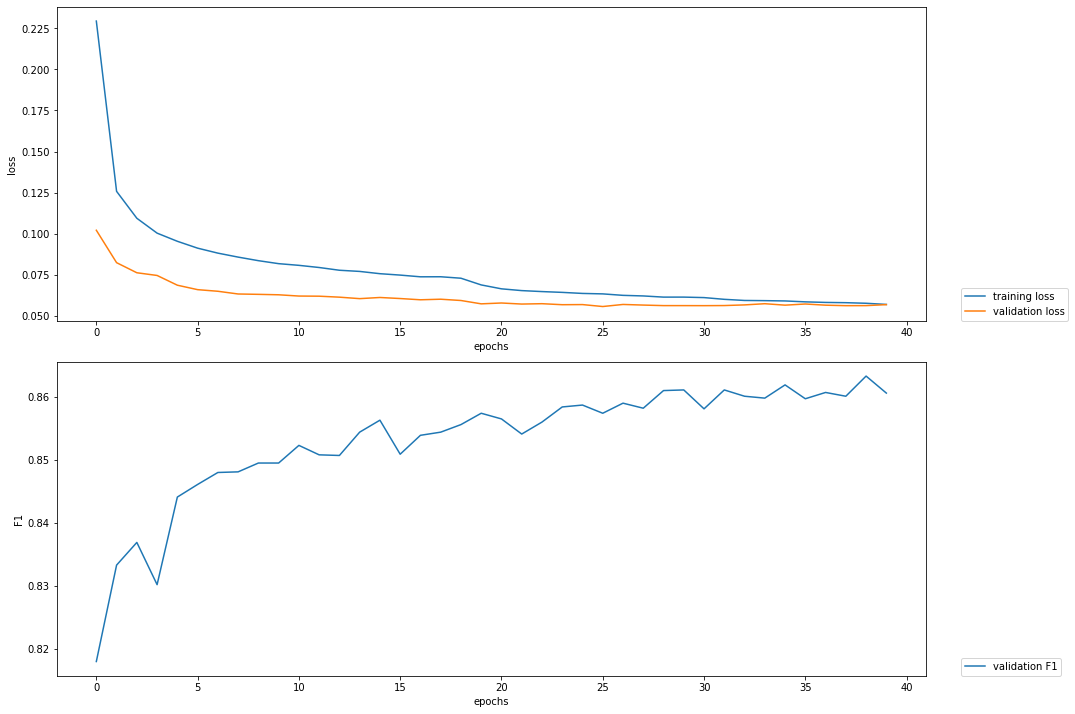

In [5]:
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves('ner_04_results/loss.tsv')

From these plots, we notice that:
- Training was sufficiently long, since the curves have flattened out
- There are no overfitting issues, since the training and validation losses are similar

### Model-Level Performance

From the training logs (see `ner_04_results/loss.tsv`), we see that our model achieved **0.86 for precision, recall, and the F1 score** on our validation set. This is an improvement over our baseline model, where we achieved **0.81**.

As explained in an earlier notebook, precision/recall/F1-score are the most common metrics used to assess NER performance. 

### Entity-Level Performance

In addition to model-level performance, we also want to investigate entity-level performance to see how well our model performed on identifying each of the individual entity tags.

Our training logs show (see `ner_04_results/training.log`):

              precision    recall  f1-score   support

         geo     0.8539    0.9128    0.8824      2959
         tim     0.8958    0.8702    0.8828      1610
         org     0.7749    0.6999    0.7355      1613
         per     0.7961    0.8215    0.8086      1378
         gpe     0.9554    0.9328    0.9440      1264
         eve     0.4500    0.2812    0.3462        32
         nat     0.8182    0.3333    0.4737        27
         art     0.5000    0.1429    0.2222        21

`support` is the number of occurrences for each entity tag in the dataset. Note that `eve` (event), `nat` (natural object), and `art` (artifact) are poorly represented in our data, so it makes sense that their scores are lower since the model doesn't have many examples to learn from.

`org` (organization) has a relatively low F1 score (**0.74**) despite having a fair number of occurrences in the dataset, but it has improved over baseline (**0.66**).